# Download keggle data

In [4]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"santaj9110","key":"166eaf611fe5389ea47fd23cfaeccc95"}'}

In [9]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json
# 본인이 참가한 모든 대회 보기 
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes         80           False  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes        105           False  
store-sales-time-series-forecasting            2030-06-30 23:59:00  Getting Started  Knowledge        911           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        166           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       1920           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      13753           False  
house-pr

In [10]:
! kaggle competitions download -c competitive-data-science-predict-future-sales

 68% 9.00M/13.3M [00:00<00:00, 56.8MB/s]
100% 13.3M/13.3M [00:00<00:00, 64.8MB/s]
  0% 0.00/2.91k [00:00<?, ?B/s]
100% 2.91k/2.91k [00:00<00:00, 2.74MB/s]
  0% 0.00/368k [00:00<?, ?B/s]
100% 368k/368k [00:00<00:00, 122MB/s]
  0% 0.00/468k [00:00<?, ?B/s]
100% 468k/468k [00:00<00:00, 161MB/s]
  0% 0.00/3.49k [00:00<?, ?B/s]
100% 3.49k/3.49k [00:00<00:00, 3.46MB/s]
  0% 0.00/1.02M [00:00<?, ?B/s]
100% 1.02M/1.02M [00:00<00:00, 145MB/s]


In [11]:
!unzip sales_train.csv.zip
!unzip items.csv.zip
!unzip test.csv.zip
!unzip  sample_submission.csv.zip


Archive:  sales_train.csv.zip
  inflating: sales_train.csv         
Archive:  items.csv.zip
  inflating: items.csv               
Archive:  test.csv.zip
  inflating: test.csv                
Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   


In [12]:
!ls

item_categories.csv  sales_train.csv	    sample_submission.csv.zip
items.csv	     sales_train.csv.zip    shops.csv
items.csv.zip	     sample_data	    test.csv
kaggle.json	     sample_submission.csv  test.csv.zip


# Library and read

In [1]:
!pip install category_encoders
!pip install eli5
!pip install pdpbox

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import iqr
from category_encoders import OrdinalEncoder,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.metrics import mean_absolute_error ,r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from pdpbox import pdp

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
categories = pd.read_csv('item_categories.csv')
items = pd.read_csv('items.csv')
train=pd.read_csv('sales_train.csv')
test = pd.read_csv('test.csv')
shops= pd.read_csv('shops.csv')
sample_sub=pd.read_csv('sample_submission.csv')

In [4]:
pd.options.display.float_format = '{:.3f}'.format

#EDA

## Data Wrangling

### Missing values

In [5]:
# check if there are missing values 
train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [6]:
# test
test.isnull().sum()

ID         0
shop_id    0
item_id    0
dtype: int64

### Duplicated data

In [7]:
# check
print((train.duplicated()==True).sum())

# Delete
train.drop_duplicates(keep='first',inplace=True)

6


In [8]:
# test
print((test.duplicated()==True).sum())

0


### Outlier

#### check- plot

[Text(0.5, 1.0, 'item_cnt_day')]

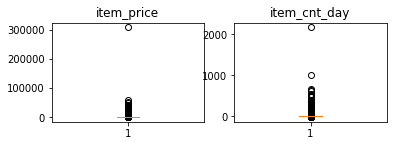

In [9]:
# plot
fig= plt.figure()

ax1=fig.add_subplot(2,2,1)
plt.boxplot(train.item_price);

ax2=fig.add_subplot(2,2,2)
plt.boxplot(train.item_cnt_day);

ax1.set(title="item_price")
ax2.set(title="item_cnt_day")

#### Item_price

##### Analyzation

In [10]:
train.item_price.describe()

count   2935843.000
mean        890.853
std        1729.801
min          -1.000
25%         249.000
50%         399.000
75%         999.000
max      307980.000
Name: item_price, dtype: float64

##### Delete neg values

In [11]:
# check how many neg values are
print((train.item_price <0).sum())

# Delete neg values
train= train[train.item_price>=0]
train.item_price.sort_values()

1


579766         0.070
608763         0.070
611400         0.087
673155         0.090
715120         0.100
             ...    
2931380    42990.000
2327159    49782.000
1488135    50999.000
885138     59200.000
1163158   307980.000
Name: item_price, Length: 2935842, dtype: float64

##### IQR 

In [12]:
# Make highest and lowest line to remove outlier
q3_pr= np.percentile(train.item_price,0.75)
iqr_pr=iqr(train.item_price)
q1_pr=q3_pr-iqr_pr
highest_pr=q3_pr + 1.5*iqr_pr
lowest_pr=q1_pr-1.5*iqr_pr

In [13]:
# check before delete
train[(train.item_price> highest_pr) | (train.item_price< lowest_pr)].count()

date              620059
date_block_num    620059
shop_id           620059
item_id           620059
item_price        620059
item_cnt_day      620059
dtype: int64

--------It could delete too many data------

##### Delete values over 99 percent

In [14]:
# Too high values are still in Datas 0.5~99.5 
# so i delete values over 99%
a=np.percentile(train.item_price,99)
train[(train.item_price> a)].count()
# delete
train= train[train.item_price< a]

In [15]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.000,1.000
1,03.01.2013,0,25,2552,899.000,1.000
2,05.01.2013,0,25,2552,899.000,-1.000
3,06.01.2013,0,25,2554,1709.050,1.000
4,15.01.2013,0,25,2555,1099.000,1.000
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.000,1.000
2935845,09.10.2015,33,25,7460,299.000,1.000
2935846,14.10.2015,33,25,7459,349.000,1.000
2935847,22.10.2015,33,25,7440,299.000,1.000


#### Item_cnt_day

##### Analyzation

In [16]:
train.item_cnt_day.describe()

count   2906299.000
mean          1.242
std           2.621
min         -22.000
25%           1.000
50%           1.000
75%           1.000
max        2169.000
Name: item_cnt_day, dtype: float64

##### Delete neg values

In [17]:
# There can not be negative values in item_cnt_day feature

# check how many neg values are
print((train.item_cnt_day <0).sum())

# Percentage
print("%0.2f%%" %((train.item_cnt_day <0).sum()/train.item_cnt_day.sum()*100))

# Delete neg values

train= train[train.item_cnt_day>=0]

# item_cnt_day = number of products sold
train.item_cnt_day.astype('int')

7160
0.20%


0          1
1          1
3          1
4          1
5          1
          ..
2935844    1
2935845    1
2935846    1
2935847    1
2935848    1
Name: item_cnt_day, Length: 2899139, dtype: int64

##### IQR

In [18]:
# Make highest and lowest line to remove outlier
q3_day= np.percentile(train.item_cnt_day,0.75)
iqr_day=iqr(train.item_cnt_day)
q1_day=q3_day-iqr_day
highest_day=q3_day + 1.5*iqr_day
lowest_day=q1_day-1.5*iqr_day

In [19]:
highest_day,lowest_day

(1.0, 1.0)

highest and lowest values are 1. so if we use this, only one value will be left

##### Delete values over 99 percent

In [20]:
b=np.percentile(train.item_cnt_day,99)
train[(train.item_cnt_day> b)].count()
#delete
train= train[train.item_cnt_day< b]

### Touch up date

In [21]:
sp_date=train['date'].str.split(pat=".")

In [22]:
# change date's order
train['year']= sp_date.map(lambda x: x[2])
train['month']= sp_date.map(lambda x: x[1])
train['day']=sp_date.map(lambda x: x[0])

train['date']= train.year+train.month+train.day

train.drop(columns='day',inplace=True)
train.drop(columns='month',inplace=True)
train.drop(columns='year',inplace=True)

# change date's type
pd.to_datetime(train['date'])


0         2013-01-02
1         2013-01-03
3         2013-01-06
4         2013-01-15
5         2013-01-10
             ...    
2935844   2015-10-10
2935845   2015-10-09
2935846   2015-10-14
2935847   2015-10-22
2935848   2015-10-03
Name: date, Length: 2861792, dtype: datetime64[ns]

##Create features

### Concat train and test

In [23]:
## The date of test set is November 2015
## date_block_number= 34

test['date_block_num']=34

In [24]:
train=pd.concat([train,test])

### 1.Create: city

In [25]:
# Extract city name
shops['city'] = shops['shop_name'].apply(lambda x: x.split()[0])
# Adjust city's name
shops.loc[shops['city']=='!Якутск','city']='Якутск'

# Drop shop_name
shops.drop(columns='shop_name',inplace=True)

### 2.Create: type ,sub type

In [26]:
#split
sp_cats= categories['item_category_name'].str.split(pat="-")
sp_cats

0      [PC ,  Гарнитуры/Наушники]
1             [Аксессуары ,  PS2]
2             [Аксессуары ,  PS3]
3             [Аксессуары ,  PS4]
4             [Аксессуары ,  PSP]
                 ...             
79                    [Служебные]
80          [Служебные ,  Билеты]
81      [Чистые носители (шпиль)]
82    [Чистые носители (штучные)]
83             [Элементы питания]
Name: item_category_name, Length: 84, dtype: object

In [27]:
# Strip whitespaces
categories['type']= sp_cats.apply(lambda x: x[0].strip())

# Adjust type's name
categories.loc[categories.type=='Игровые консоли','type']='Игры'
categories.loc[categories.type=='Игры Android','type']='Игры'
categories.loc[categories.type=='Игры MAC','type']='Игры'
categories.loc[categories.type=='Игры PC','type']='Игры'
categories.loc[categories.type=='Карты оплаты (Кино, Музыка, Игры)','type']='Карты оплаты'
categories.loc[categories.type=='Чистые носители (шпиль)','type']='Чистые носители'
categories.loc[categories.type=='Чистые носители (штучные)','type']='Чистые носители'

categories['subtype']=sp_cats.map(lambda x: x[1].strip() if len(x)>1 else x[0].strip())
# Drop item_category_name
categories.drop(columns='item_category_name',inplace=True)
categories

,item_category_id,type,subtype
0,0,PC,Гарнитуры/Наушники
1,1,Аксессуары,PS2
2,2,Аксессуары,PS3
3,3,Аксессуары,PS4
4,4,Аксессуары,PSP
...,...,...,...
79,79,Служебные,Служебные
80,80,Служебные,Билеты
81,81,Чистые носители,Чистые носители (шпиль)
82,82,Чистые носители,Чистые носители (штучные)


### 3.Create target : item_cnt_month

In [28]:
# Make group to creat item_cnt_month
group=train.groupby(['date_block_num','shop_id','item_id'])['item_cnt_day'].agg([sum])
# Merge
train = train.merge(group, on=['date_block_num','shop_id','item_id'], how='left')
# Rename
train.rename(columns={'sum':'item_cnt_month'},inplace=True)

target='item_cnt_month'

# Drop item_cnt_day
train.drop(columns='item_cnt_day',inplace=True);

#### Merge 1,2,3

In [29]:
# items + categories to join train data
items=items.merge(categories,on='item_category_id')

items.drop(columns='item_name',inplace=True)

In [30]:
train= train.merge(shops,on='shop_id',how='left')
train= train.merge(items,on='item_id',how='left')

### Make function for making mean features grouped

In [31]:
## https://www.kaggle.com/hadeux/simple-lgbmregressor-baseline

def add_mean(df, idx_features):
    # Check base features
    assert (idx_features[0] == 'date_block_num') and \
           len(idx_features) in [2, 3]
    
    # Set derived feature name 
    if len(idx_features) == 2:
        feature_name = idx_features[1] + '_mean_sales'
    else:
        feature_name = idx_features[1] + '_' + idx_features[2] + '_mean_sales'
    
    # Get average monthly sales by grouping based on base features
    group = df.groupby(idx_features).agg({'item_cnt_month': 'mean'})
    group = group.reset_index()
    group = group.rename(columns={'item_cnt_month': feature_name})
    
    # Merge df with group based on idx_features
    df = df.merge(group, on=idx_features, how='left')
    
    return df

In [32]:
## ['date_block_num', 'item_id']
train = add_mean(df=train, idx_features=['date_block_num', 'item_id'])

##['date_block_num', 'shop_id']
train = add_mean(df=train, idx_features=['date_block_num', 'shop_id'])

## ['date_block_num', 'item_category_id']
train = add_mean(df=train, idx_features=['date_block_num', 'item_category_id'])

## ['date_block_num', 'item_id', 'city']
train = add_mean(df=train, idx_features=['date_block_num', 'item_id', 'city'])

## ['date_block_num', 'shop_id', 'item_category_id']
train = add_mean(df=train, idx_features=['date_block_num', 'shop_id', 'item_category_id'])



In [33]:
# Create monthly average sales derived features grouped by ['date_block_num', 'shop_id', 'subtype_code']
train = add_mean(df=train, idx_features=['date_block_num', 'shop_id', 'subtype'])

## Adjust features for modeling



In [34]:
val=train[train['date_block_num']==33]
test=train[train['date_block_num']==34]
train=train[train['date_block_num']<33]

## Check before modeling

#Modeling

### baseline= mean

In [35]:
target= 'item_cnt_month'

X_train= train.drop(columns=target)
y_train=train[target]

X_val=val.drop(columns=target)
y_val=val[target]

test= test.drop(columns=target)

In [36]:
X_train.fillna(0,inplace=True)
X_val.fillna(0,inplace=True)

In [37]:
y_train.describe()

count   2810130.000
mean          4.770
std           6.860
min           1.000
25%           1.000
50%           2.000
75%           5.000
max          75.000
Name: item_cnt_month, dtype: float64

In [38]:
predict=y_train.mean()

y_pred= [predict]*len(y_train)
rmse= mean_squared_error(y_train,y_pred)**0.5

rmse

6.860145072198136

In [39]:
y_pred= [predict]*len(y_val)
rmse= mean_squared_error(y_val,y_pred)**0.5

rmse

7.100604978763966

### XGB

In [189]:
pipe =Pipeline([
                ('preprocessing',make_pipeline(OrdinalEncoder())),
                ('xg',XGBRegressor(n_estimators=100, random_state=2, n_jobs=-1))
])

In [190]:
pipe.named_steps

{'preprocessing': Pipeline(steps=[('ordinalencoder', OrdinalEncoder())]),
 'xg': XGBRegressor(n_jobs=-1, random_state=2)}

In [191]:
pipe.fit(X_train, y_train)

[07:27:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('ordinalencoder',
                                  OrdinalEncoder(cols=['date', 'city', 'type',
                                                       'subtype'],
                                                 mapping=[{'col': 'date',
                                                           'data_type': dtype('O'),
                                                           'mapping': 20130102       1
20130103       2
20130106       3
20130115       4
20130110       5
            ... 
20150917    1000
20150914    1001
20150930    1002
20150915    1003
NaN           -2
Length: 1004, dtype: int64},
                                                          {'col': 'city',
                                                           'data_type': dtype('O'),
                                                           'mapping': Я...
Чистые носители      9
Служебные           10
PC                  11
Элементы питания    12

In [192]:
## rmse
y_pred=pipe.predict(X_val)
rmse= mean_squared_error(y_val,y_pred)**0.5

rmse

1.3846079224724963

 r2 score

In [193]:
r2=r2_score(y_val,y_pred)

r2

0.9618102610533826

## PermutationImportance

In [194]:
permuter = PermutationImportance(
    pipe.named_steps['xg'],
    
    n_iter=30,
    random_state=2
)

X_val_transformed = pipe.named_steps['preprocessing'].transform(X_val)
permuter.fit(X_val_transformed, y_val);

In [195]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

date                                  0.000
date_block_num                        0.000
ID                                    0.000
item_category_id                      0.000
type                                  0.000
subtype                               0.000
item_price                            0.000
item_id                               0.000
shop_id_mean_sales                    0.004
shop_id                               0.004
city                                  0.004
item_id_mean_sales                    0.010
shop_id_subtype_mean_sales            0.024
item_category_id_mean_sales           0.067
shop_id_item_category_id_mean_sales   0.216
item_id_city_mean_sales               1.253
dtype: float64

In [196]:
eli5.show_weights(
    permuter, 
    top=None,
    feature_names=feature_names
)

Weight,Feature
1.2526 ± 0.0109,item_id_city_mean_sales
0.2161 ± 0.0041,shop_id_item_category_id_mean_sales
0.0670 ± 0.0011,item_category_id_mean_sales
0.0236 ± 0.0008,shop_id_subtype_mean_sales
0.0103 ± 0.0003,item_id_mean_sales
0.0044 ± 0.0003,city
0.0044 ± 0.0003,shop_id
0.0038 ± 0.0002,shop_id_mean_sales
0.0003 ± 0.0000,item_id
0.0002 ± 0.0000,item_price


### Delete features under 0.0001

In [197]:
## Delete features

minimum_importance =0.0001
mask=permuter.feature_importances_>=minimum_importance

features = X_train.columns[mask]
X_train_selected = X_train[features]
test_selected=test[features]
X_val_selected=X_val[features]

In [198]:
pipe =Pipeline([
                ('preprocessing',make_pipeline(OrdinalEncoder())),
                ('xg',XGBRegressor(n_estimators=100, random_state=2, n_jobs=-1))
])

In [199]:
pipe.fit(X_train_selected,y_train)

[07:31:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('ordinalencoder',
                                  OrdinalEncoder(cols=['city', 'type',
                                                       'subtype'],
                                                 mapping=[{'col': 'city',
                                                           'data_type': dtype('O'),
                                                           'mapping': Ярославль            1
Москва               2
Курск                3
Красноярск           4
Волжский             5
Воронеж              6
Адыгея               7
Балашиха             8
Якутск               9
Коломна             10
Калуга              11
Жуковский           12
Казань              13
Интернет-магазин    14
Уфа                 15
Н.Новгород          16
Чехов               17
Химки               18
Сургут              19
Тюмень              20
СПб                 21
Р...
Чистые носители      9
Служебные           10
PC            

In [200]:
y_pred=pipe.predict(X_val_selected)
rmse= mean_squared_error(y_val,y_pred)**0.5

rmse

1.3846079224724963

## gradient boosting regressor


In [40]:
encoder = OrdinalEncoder()

X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

boosting = XGBRegressor(
    n_estimators=1000,
    objective='reg:squarederror',
    learning_rate=0.2,
    n_jobs=-1
)

eval_set=[(X_train_encoded,y_train),(X_val_encoded,y_val)]

boosting.fit(X_train_encoded,y_train,
             eval_set=eval_set,
             early_stopping_rounds=50
)

## [195]	validation_0-rmse:3.80279	validation_1-rmse:3.43746

[0]	validation_0-rmse:6.65841	validation_1-rmse:6.58531
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:5.55844	validation_1-rmse:5.43938
[2]	validation_0-rmse:4.70309	validation_1-rmse:4.54242
[3]	validation_0-rmse:4.04699	validation_1-rmse:3.87471
[4]	validation_0-rmse:3.54335	validation_1-rmse:3.34929
[5]	validation_0-rmse:3.16027	validation_1-rmse:2.93215
[6]	validation_0-rmse:2.88052	validation_1-rmse:2.67849
[7]	validation_0-rmse:2.68075	validation_1-rmse:2.4476
[8]	validation_0-rmse:2.53293	validation_1-rmse:2.26795
[9]	validation_0-rmse:2.41559	validation_1-rmse:2.162
[10]	validation_0-rmse:2.33241	validation_1-rmse:2.06422
[11]	validation_0-rmse:2.2739	validation_1-rmse:1.98944
[12]	validation_0-rmse:2.22733	validation_1-rmse:1.90542
[13]	validation_0-rmse:2.17185	validation_1-rmse:1.85273
[14]	validation_0-rmse:2.14284	validation_1-rmse:1.80634


XGBRegressor(learning_rate=0.2, n_estimators=1000, n_jobs=-1,
             objective='reg:squarederror')

In [180]:
y_pred = boosting.predict(X_val_encoded)
print('R^2', r2_score(y_val, y_pred))

R^2 0.9759462183774221


to csv

In [182]:
test_encoded= encoder.fit_transform(test)

y_pred=boosting.predict(test_encoded)

In [183]:
a=pd.DataFrame(y_pred).reset_index()

In [184]:
a.rename(columns={'index':'ID',0:'item_cnt_month'},inplace=True)

In [185]:
a.to_csv(path_or_buf='subb2.csv',index=False)

## Decision tree regressor 

In [205]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2810130 entries, 0 to 2810129
Data columns (total 16 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   date                                 object 
 1   date_block_num                       int64  
 2   shop_id                              int64  
 3   item_id                              int64  
 4   item_price                           float64
 5   ID                                   float64
 6   city                                 object 
 7   item_category_id                     int64  
 8   type                                 object 
 9   subtype                              object 
 10  item_id_mean_sales                   float64
 11  shop_id_mean_sales                   float64
 12  item_category_id_mean_sales          float64
 13  item_id_city_mean_sales              float64
 14  shop_id_item_category_id_mean_sales  float64
 15  shop_id_subtype_mean_sales      

In [206]:
X_train.fillna(0,inplace=True)

pipe = make_pipeline(
    OrdinalEncoder(),  
    DecisionTreeRegressor(min_samples_split=2,
                          min_samples_leaf=2,
                          max_features=10
                          )
)



pipe.fit(X_train, y_train);

In [210]:
y_pred=pipe.predict(X_val)
rmse= mean_squared_error(y_val,y_pred)**0.5

rmse

1.7600711796911104

In [211]:
r2=r2_score(y_val,y_pred)

r2

0.9382902867335376

## RidgeCV

In [37]:
pipe =make_pipeline(
    OrdinalEncoder(),
    RidgeCV(cv=3)
)

pipe.fit(X_train,y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['date', 'city', 'type', 'subtype'],
                                mapping=[{'col': 'date',
                                          'data_type': dtype('O'),
                                          'mapping': 20130102       1
20130103       2
20130106       3
20130115       4
20130110       5
            ... 
20150917    1000
20150914    1001
20150930    1002
20150915    1003
NaN           -2
Length: 1004, dtype: int64},
                                         {'col': 'city',
                                          'data_type': dtype('O'),
                                          'mapping': Ярославль            1
Москва               2
Курск                3
Красноярск           4...
Служебные           10
PC                  11
Элементы питания    12
Доставка товара     13
Билеты (Цифра)      14
NaN                 -2
dtype: int64},
                                         {'col': 'subtype',
             

In [38]:
y_pred=pipe.predict(X_val)

r2=r2_score(y_val,y_pred)

r2

0.918690672741245

In [39]:
y_pred=pipe.predict(X_val)
rmse= mean_squared_error(y_val,y_pred)**0.5

rmse

2.0203362268810454

standard scaled

In [ ]:
pipe =make_pipeline(
    OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    RidgeCV(cv=5)
)

pipe.fit(X_train,y_train)

In [ ]:
y_pred=pipe.predict(X_val)

r2=r2_score(y_val,y_pred)

r2

# PDP

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


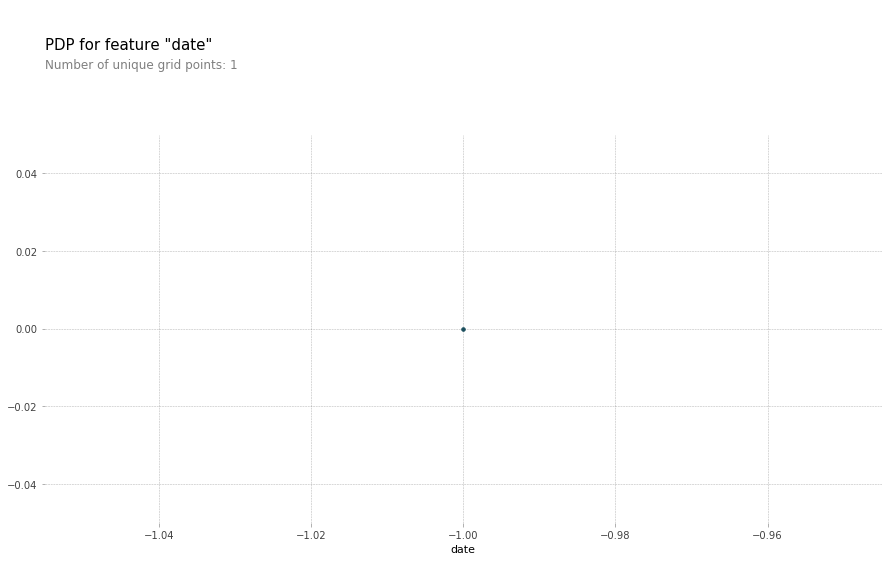

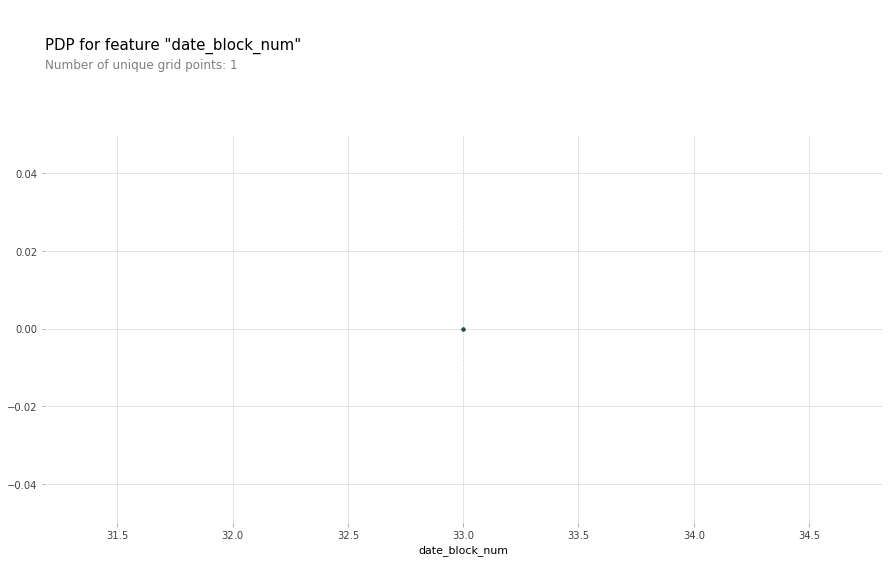

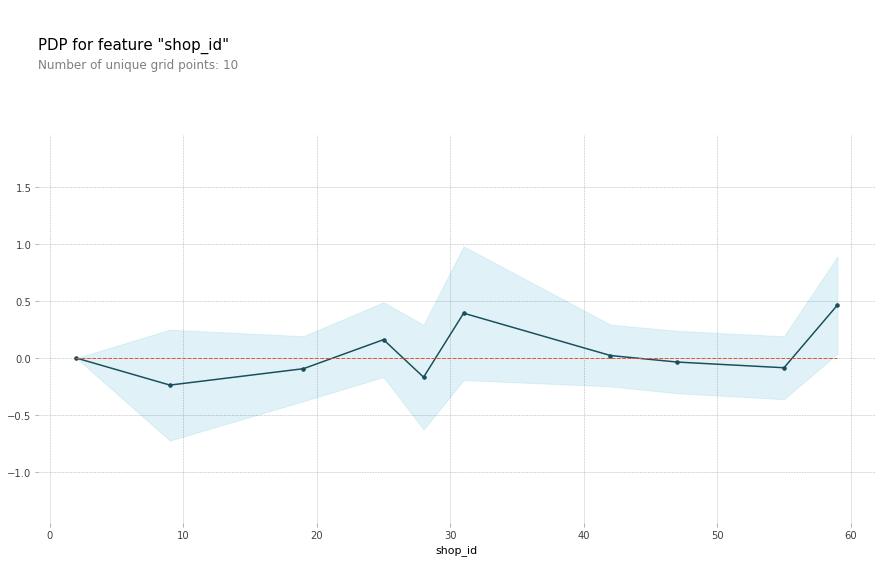

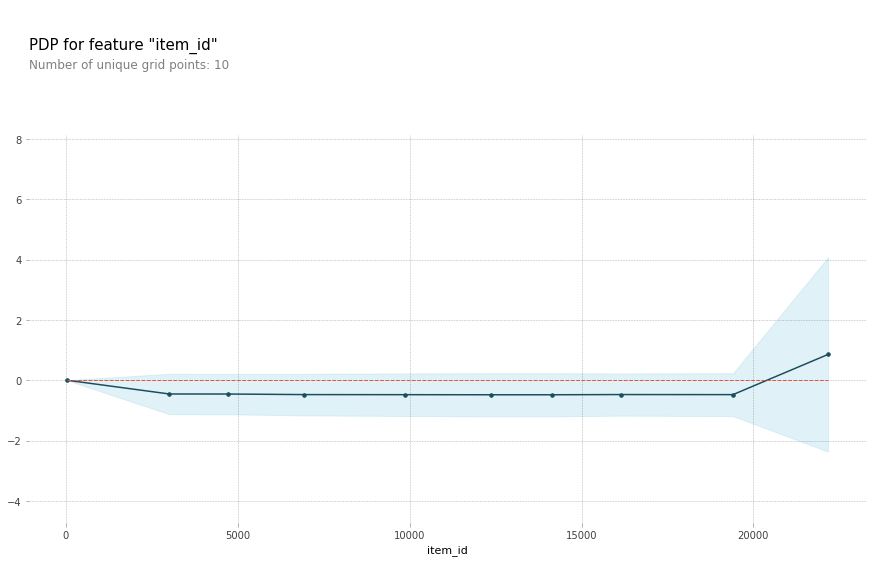

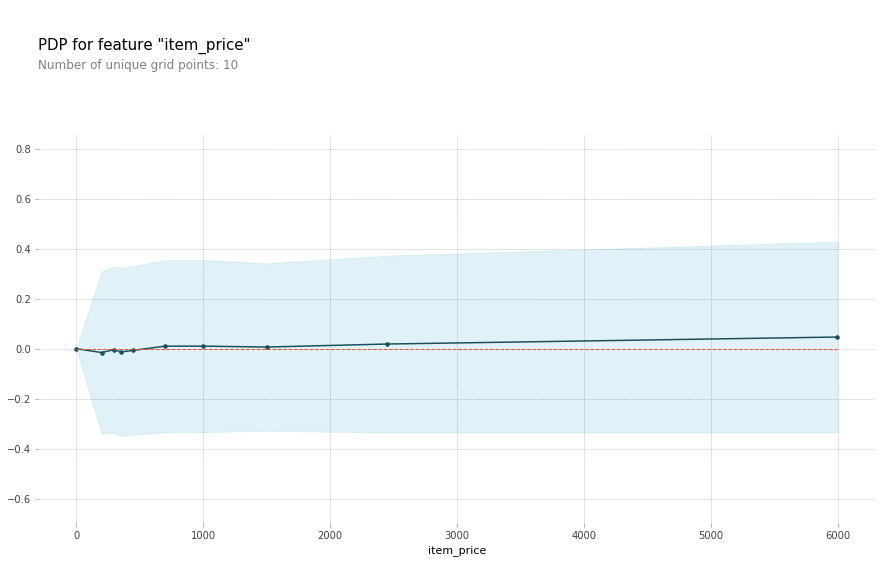

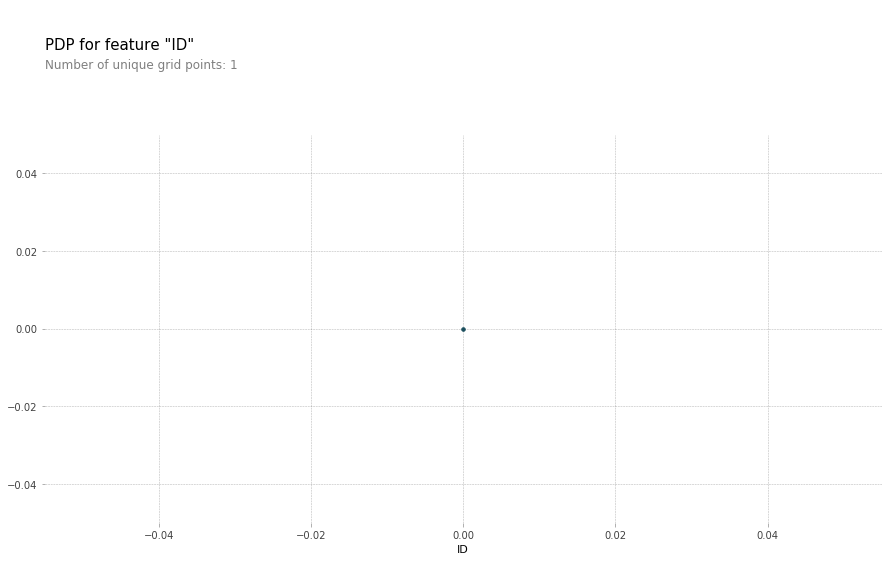

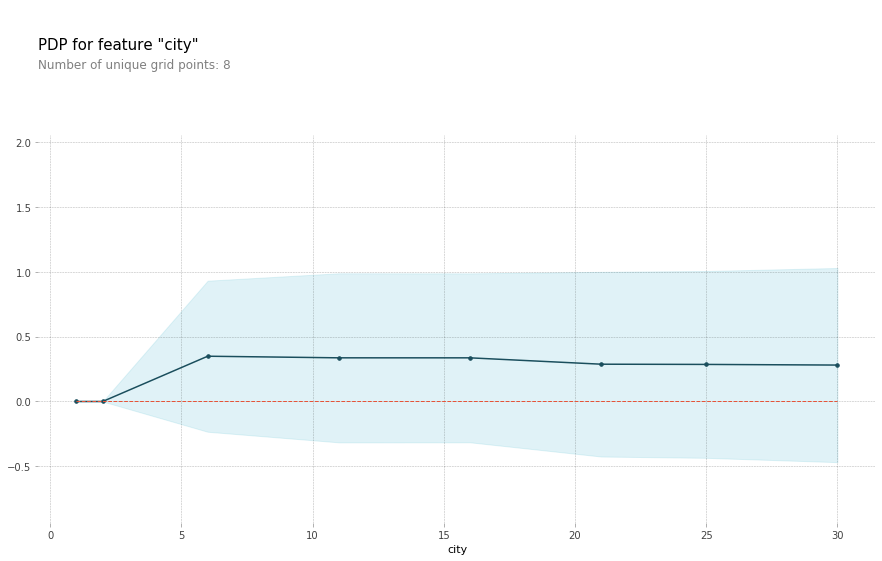

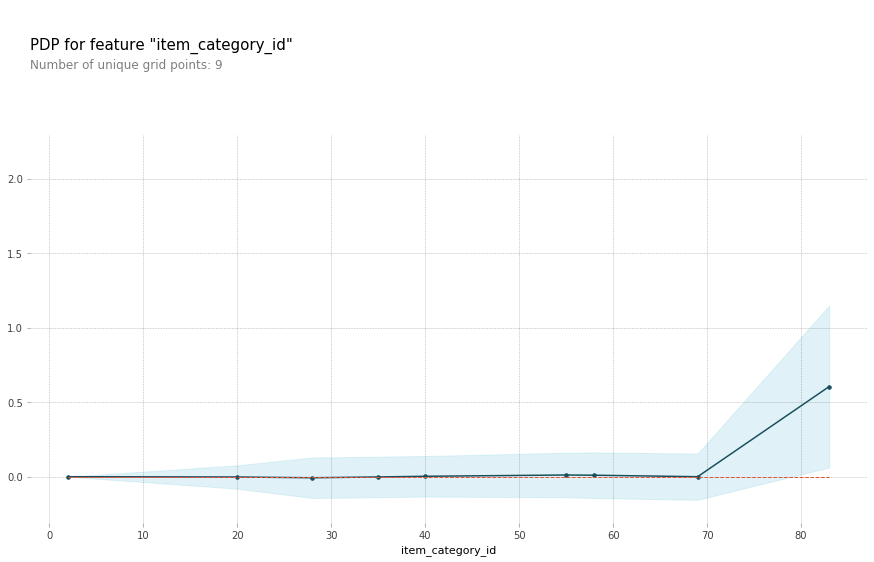

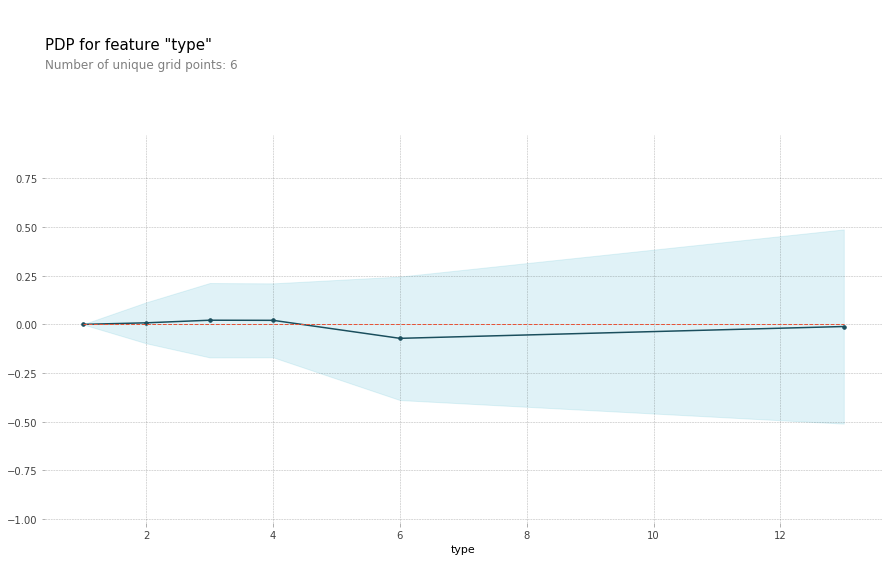

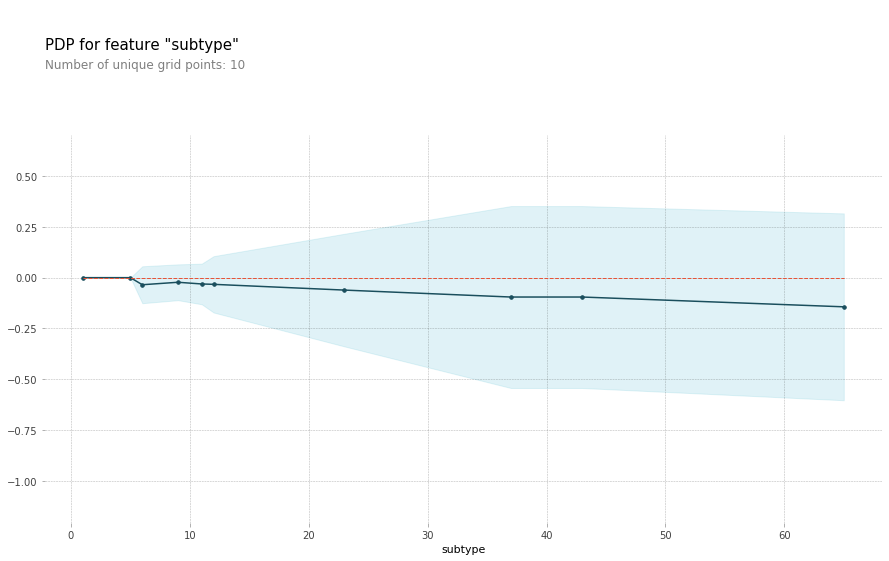

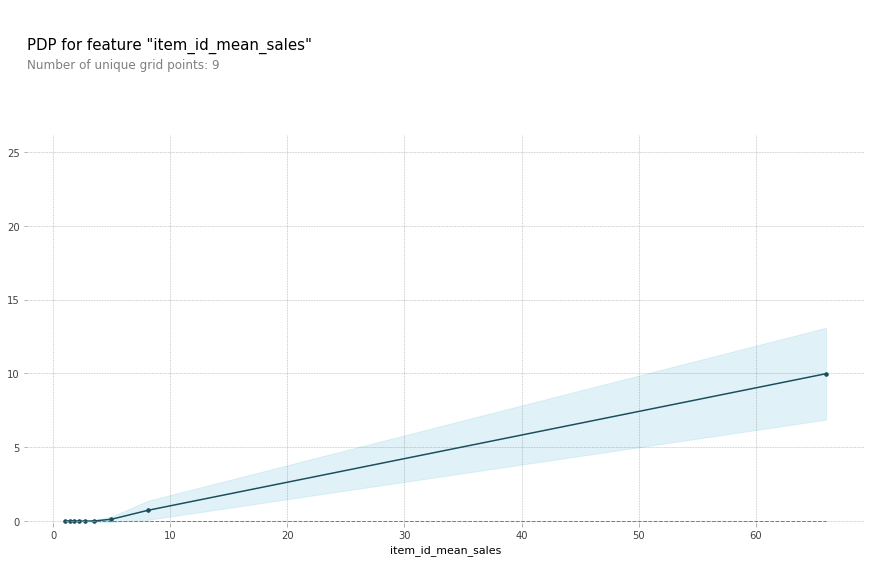

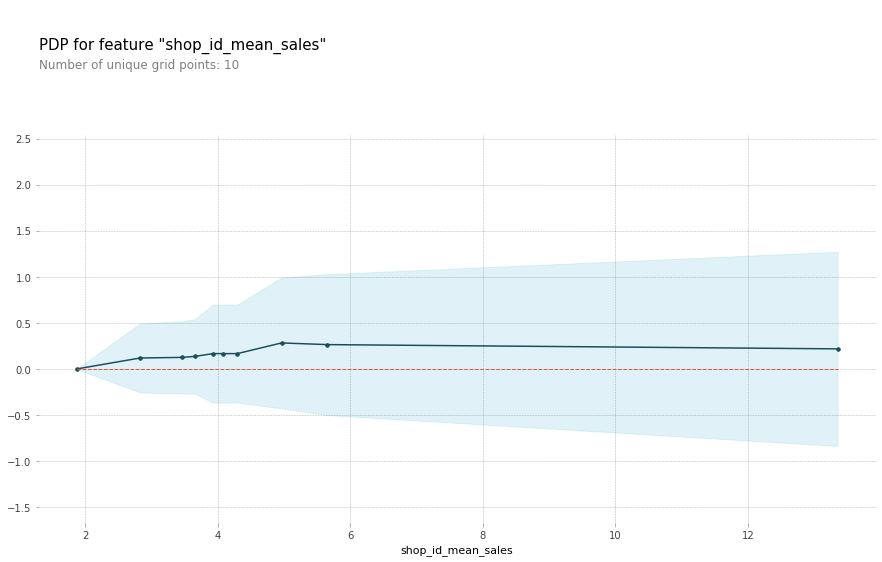

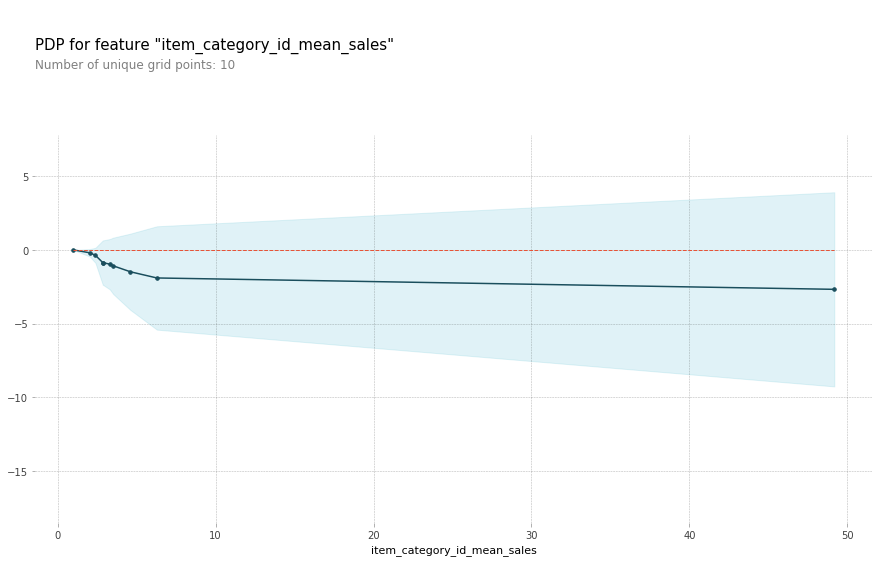

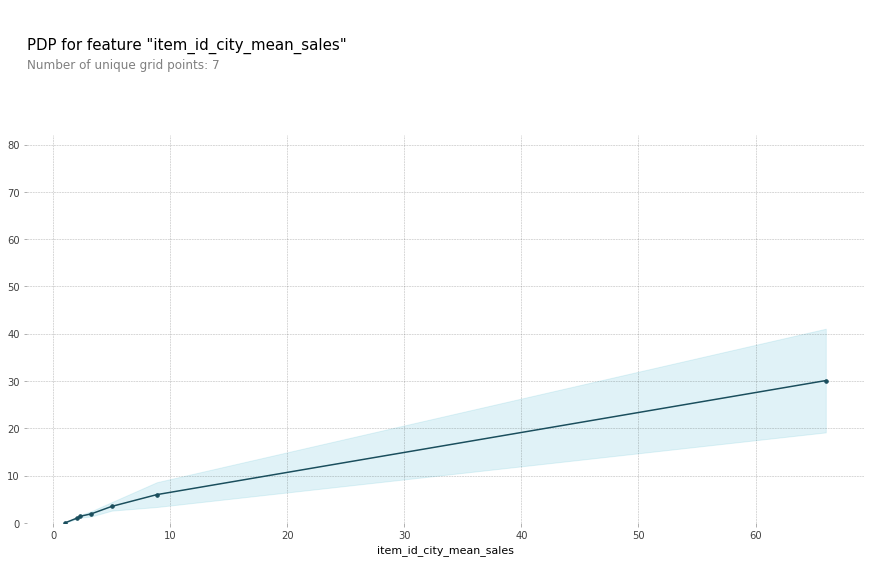

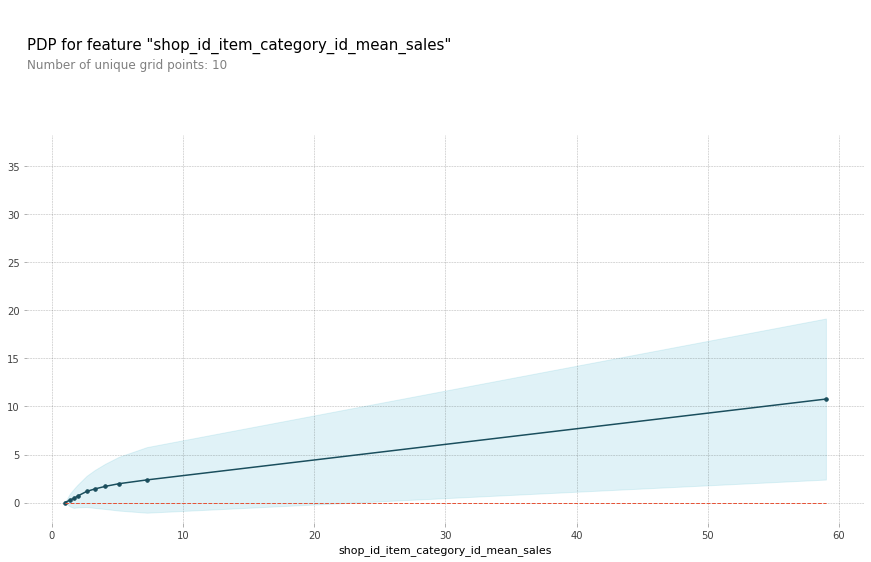

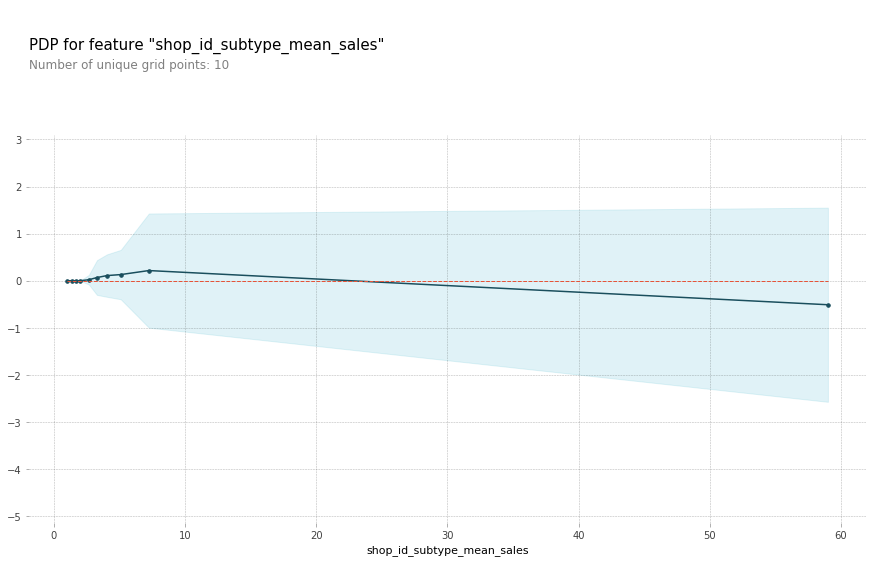

In [41]:
for i in X_train.columns:
    feature = i
    features = X_val_encoded.columns
    pdp_dist = pdp.pdp_isolate(model=boosting, dataset=X_val_encoded, model_features=features, feature=feature)
    pdp.pdp_plot(pdp_dist, feature);